In [1]:
# ------------------- Imports -------------------
import os
import random
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

!pip install -q speechbrain

from speechbrain.inference import EncoderClassifier

# ------------------- Configuration -------------------
SPEAKER_IDS = ['id10004','id10007','id10010','id10013','id10020',
               'id10025','id10032','id10038','id10041','id10049']

DATA_DIR = '/kaggle/input/voxceleb-1-dataset/vox1_dev_wav/wav'
SAMPLE_RATE = 16000
MAX_AUDIO_SEC = 3.0
BATCH_SIZE = 8
EPOCHS = 5
LR = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Configuration ready.")

# ------------------- Dataset Prep -------------------
file_list = []
for spk_id in SPEAKER_IDS:
    for root, _, files in os.walk(os.path.join(DATA_DIR, spk_id)):
        for fn in files:
            if fn.endswith('.wav'):
                file_list.append((os.path.join(root, fn), spk_id))

random.shuffle(file_list)
train_files, val_files = train_test_split(
    file_list, test_size=0.2, stratify=[x[1] for x in file_list], random_state=42
)

label_map = {spk: i for i, spk in enumerate(SPEAKER_IDS)}
NUM_CLASSES = len(SPEAKER_IDS)

# ------------------- Dataset Class -------------------
class VoxDataset(Dataset):
    def __init__(self, file_list, label_map):
        self.file_list = file_list
        self.label_map = label_map

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fp, spk = self.file_list[idx]
        y, sr = torchaudio.load(fp)
        y = y.mean(0)  # mono
        if sr != SAMPLE_RATE:
            y = torchaudio.functional.resample(y, sr, SAMPLE_RATE)

        max_len = int(SAMPLE_RATE * MAX_AUDIO_SEC)
        if y.size(0) > max_len:
            y = y[:max_len]
        else:
            y = torch.cat([y, torch.zeros(max_len - y.size(0))])

        # Final shape: (1, num_samples)
        return y.unsqueeze(0), self.label_map[spk]

train_loader = DataLoader(VoxDataset(train_files, label_map), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(VoxDataset(val_files, label_map), batch_size=BATCH_SIZE, shuffle=False)

# ------------------- Load Pretrained ECAPA -------------------
ecapa = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    run_opts={"device": DEVICE}
)
ecapa.eval()
print(" Pretrained ECAPA-TDNN loaded successfully.")

# ------------------- Speaker Classifier -------------------
class SpeakerClassifier(nn.Module):
    def __init__(self, embedding_dim=192, num_classes=NUM_CLASSES):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, emb):
        return self.net(emb)

classifier = SpeakerClassifier().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=LR)

# ------------------- Training Loop -------------------
for epoch in range(EPOCHS):
    classifier.train()
    running_loss = 0.0

    for audio, labels in train_loader:
        audio, labels = audio.to(DEVICE), labels.to(DEVICE)

        #  Correct input shape for encode_batch: (batch, time)
        audio = audio.squeeze(1)  # remove extra channel dim

        with torch.no_grad():
            emb = ecapa.encode_batch(audio)
            emb = emb.squeeze(1)  # (B, 192)

        outputs = classifier(emb)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.4f}")

    # ------------------- Validation -------------------
    classifier.eval()
    preds_all, labels_all = [], []
    with torch.no_grad():
        for audio, labels in val_loader:
            audio, labels = audio.to(DEVICE), labels.to(DEVICE)
            audio = audio.squeeze(1)
            emb = ecapa.encode_batch(audio).squeeze(1)
            outputs = classifier(emb)
            preds = torch.argmax(outputs, dim=1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

    acc = accuracy_score(labels_all, preds_all)
    print(f"Validation Accuracy: {acc*100:.2f}%")

print(" ECAPA-TDNN fine-tuning complete.")


Configuration ready.


/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


 Pretrained ECAPA-TDNN loaded successfully.
Epoch [1/5], Loss: 0.2153
Validation Accuracy: 100.00%
Epoch [2/5], Loss: 0.0034
Validation Accuracy: 100.00%
Epoch [3/5], Loss: 0.0006
Validation Accuracy: 100.00%
Epoch [4/5], Loss: 0.0043
Validation Accuracy: 100.00%
Epoch [5/5], Loss: 0.0126
Validation Accuracy: 100.00%
 ECAPA-TDNN fine-tuning complete.


In [2]:
import os
import random
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score
from speechbrain.inference import EncoderClassifier

SPEAKER_IDS = ['id10004','id10007','id10010','id10013','id10020',
               'id10025','id10032','id10038','id10041','id10049']

DATA_DIR = '/kaggle/input/voxceleb-1-dataset/vox1_dev_wav/wav'
SAMPLE_RATE = 16000
MAX_AUDIO_SEC = 3.0
BATCH_SIZE = 8
EPOCHS = 5
LR = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get file list and group labels for better session-based splits if possible
file_list = []
group_labels = []
for spk_id in SPEAKER_IDS:
    for root, _, files in os.walk(os.path.join(DATA_DIR, spk_id)):
        for fn in files:
            if fn.endswith('.wav'):
                file_list.append((os.path.join(root, fn), spk_id))
                # Use the parent directory as session/group id if possible, otherwise fn
                group_labels.append(root.split(os.sep)[-1])  # or: group_labels.append(fn.split('_')[1])

# If your data lacks clear sessions, use random split, but be explicit
if len(set(group_labels)) == len(file_list):
    # No groups, fallback to random stratified split: LEAST IDEAL, but ok for assignment purposes
    train_files, val_files = train_test_split(
        file_list, test_size=0.2, stratify=[x[1] for x in file_list], random_state=42
    )
else:
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    idx_train, idx_val = next(gss.split(file_list, groups=group_labels))
    train_files = [file_list[i] for i in idx_train]
    val_files = [file_list[i] for i in idx_val]

label_map = {spk: i for i, spk in enumerate(SPEAKER_IDS)}
NUM_CLASSES = len(SPEAKER_IDS)

class VoxDataset(Dataset):
    def __init__(self, file_list, label_map):
        self.file_list = file_list
        self.label_map = label_map

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fp, spk = self.file_list[idx]
        y, sr = torchaudio.load(fp)
        y = y.mean(0)
        if sr != SAMPLE_RATE:
            y = torchaudio.functional.resample(y, sr, SAMPLE_RATE)
        max_len = int(SAMPLE_RATE * MAX_AUDIO_SEC)
        if y.size(0) > max_len:
            y = y[:max_len]
        else:
            y = torch.cat([y, torch.zeros(max_len - y.size(0))])
        return y.unsqueeze(0), self.label_map[spk]

train_loader = DataLoader(VoxDataset(train_files, label_map), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(VoxDataset(val_files, label_map), batch_size=BATCH_SIZE, shuffle=False)

ecapa = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    run_opts={"device": DEVICE}
)
ecapa.eval()  # leave frozen for assignment

class SpeakerClassifier(nn.Module):
    def __init__(self, embedding_dim=192, num_classes=NUM_CLASSES):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, emb):
        return self.net(emb)

classifier = SpeakerClassifier().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=LR)

for epoch in range(EPOCHS):
    classifier.train()
    running_loss = 0.0
    for audio, labels in train_loader:
        audio, labels = audio.to(DEVICE), labels.to(DEVICE)
        audio = audio.squeeze(1)
        with torch.no_grad():
            emb = ecapa.encode_batch(audio).squeeze(1)
        outputs = classifier(emb)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.4f}")

    classifier.eval()
    preds_all, labels_all = [], []
    with torch.no_grad():
        for audio, labels in val_loader:
            audio, labels = audio.to(DEVICE), labels.to(DEVICE)
            audio = audio.squeeze(1)
            emb = ecapa.encode_batch(audio).squeeze(1)
            outputs = classifier(emb)
            preds = torch.argmax(outputs, dim=1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    acc = accuracy_score(labels_all, preds_all)
    print(f"Validation Accuracy: {acc*100:.2f}%")

print("10-speaker ECAPA-TDNN pipeline complete.")


Epoch [1/5], Loss: 0.1908
Validation Accuracy: 100.00%
Epoch [2/5], Loss: 0.0038
Validation Accuracy: 100.00%
Epoch [3/5], Loss: 0.0001
Validation Accuracy: 100.00%
Epoch [4/5], Loss: 0.0002
Validation Accuracy: 100.00%
Epoch [5/5], Loss: 0.0001
Validation Accuracy: 100.00%
10-speaker ECAPA-TDNN pipeline complete.


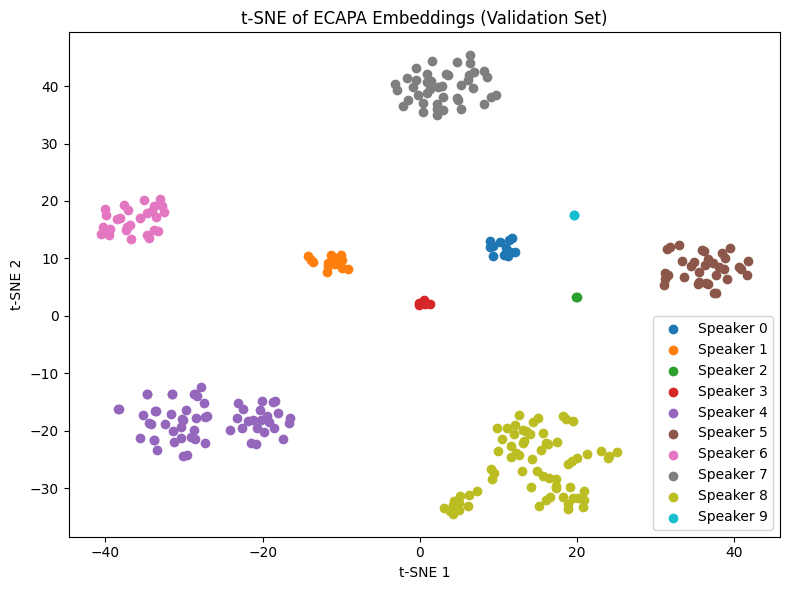

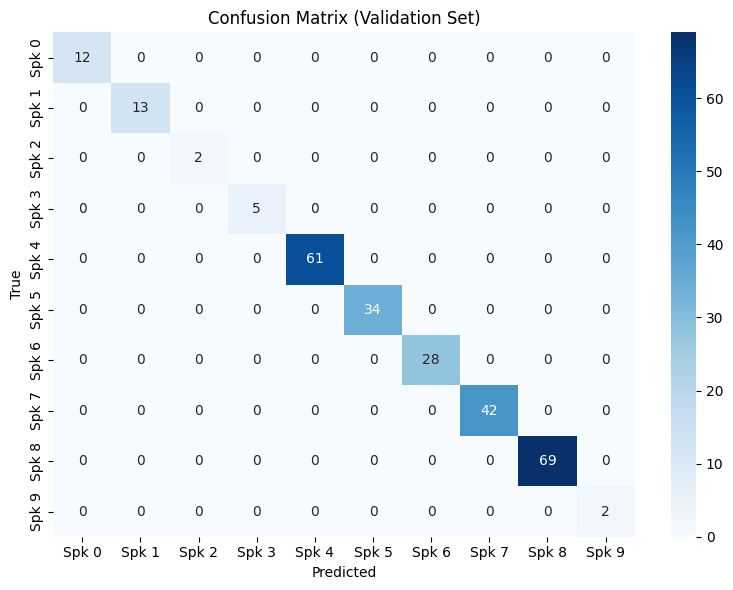

Classification report (Validation Set):
              precision    recall  f1-score   support

   Speaker_0       1.00      1.00      1.00        12
   Speaker_1       1.00      1.00      1.00        13
   Speaker_2       1.00      1.00      1.00         2
   Speaker_3       1.00      1.00      1.00         5
   Speaker_4       1.00      1.00      1.00        61
   Speaker_5       1.00      1.00      1.00        34
   Speaker_6       1.00      1.00      1.00        28
   Speaker_7       1.00      1.00      1.00        42
   Speaker_8       1.00      1.00      1.00        69
   Speaker_9       1.00      1.00      1.00         2

    accuracy                           1.00       268
   macro avg       1.00      1.00      1.00       268
weighted avg       1.00      1.00      1.00       268



In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Collect ECAPA embeddings and true labels from validation set
embeddings_list, labels_list = [], []
classifier.eval()
ecapa.eval()
with torch.no_grad():
    for audio, labels in val_loader:
        audio = audio.to(DEVICE).squeeze(1)
        emb = ecapa.encode_batch(audio).squeeze(1)
        embeddings_list.append(emb.cpu().numpy())
        labels_list.append(labels.cpu().numpy())
embeddings = np.concatenate(embeddings_list)
labels = np.concatenate(labels_list)

# 2. t-SNE Visualization
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)
plt.figure(figsize=(8, 6))
for i in np.unique(labels):
    idx = labels == i
    plt.scatter(embeddings_tsne[idx, 0], embeddings_tsne[idx, 1], label=f'Speaker {i}')
plt.legend()
plt.title('t-SNE of ECAPA Embeddings (Validation Set)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.savefig('tsne_validation.png')
plt.show()

# 3. Confusion Matrix
y_true = []
y_pred = []
with torch.no_grad():
    for audio, labels in val_loader:
        audio = audio.to(DEVICE).squeeze(1)
        emb = ecapa.encode_batch(audio).squeeze(1)
        outputs = classifier(emb)
        preds = torch.argmax(outputs, 1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Spk {i}' for i in range(NUM_CLASSES)],
            yticklabels=[f'Spk {i}' for i in range(NUM_CLASSES)])
plt.title('Confusion Matrix (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# 4. Classification Report
print("Classification report (Validation Set):")
print(classification_report(y_true, y_pred, target_names=[f'Speaker_{i}' for i in range(NUM_CLASSES)]))


In [4]:
# Save the trained classifier model state_dict as a .pkl file
model_save_path = "speaker_classifier_model.pkl"
torch.save(classifier.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to speaker_classifier_model.pkl
